In [253]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
import math
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Base Model
$e_n^{target} = (r_n - r_n^{est})$

$r_{n+1}^{est} = Ar_n^{est} + Be_n^{target}$

In [122]:
num_trials = 640
def base_model_sudden(num_trials, A, B):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90
    rotation_est = 0
    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors

def base_model_gradual(num_trials, A, B):
#    A = np.exp(A)/(1 + np.exp(A))
#    B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors

In [142]:
def base_model_transfer(num_trials, A, B):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90
    rotation_est = 0
    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors


# Data
## Curvatures

In [123]:
def calc_angle(current_point, next_point, final_point):
    vec1 = next_point - current_point
    vec2 = final_point - current_point
    cos_theta = np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))
    theta = np.degrees(np.arccos(cos_theta))
    return theta

def calc_curvature(data, block, trial, percentage_trajectory):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
    targetx, targety = trajx[-1], trajy[-1]
    partial_trajx, partial_trajy = get_partial_traj(data, block, trial, percentage_trajectory)
    angles = list([0])
    for i in range(len(partial_trajx[:-1])):
        #print (trajx[i], trajy[i])
        angles.append(calc_angle(np.array([partial_trajx[i], partial_trajy[i]]), np.array([partial_trajx[i+1], partial_trajy[i+1]]), np.array([trajx[-1], trajy[-1]])))
    return np.nanmedian(angles)

def get_traj(data, block, trial):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    x_traj = traj['x'][0][trial][0]
    y_traj = traj['y'][0][trial][0]
    return x_traj, y_traj

def get_partial_traj(data, block, trial, percentage_trajectory):
    traj = get_traj(data, block, trial)
    dist_cutoff = percentage_trajectory*np.sqrt(212**2 + 212**2, dtype = float)
    for i in range(len(traj[0])):
        dist_from_start = np.sqrt(traj[0][i]**2 + traj[1][i]**2, dtype = float)
        if dist_from_start > dist_cutoff:
            break
    partial_trajx = traj[0][:i]
    partial_trajy = traj[1][:i]
        
            
    return partial_trajx, partial_trajy



In [4]:
curvatures = np.zeros((60, 12, 64))
for data in range(60):
    for block in range(12):
        for trial in range(64):
            curvatures[data][block][trial] = calc_curvature(data+1000, block, trial, 0.5)
    if data%10 == 0:
        print (data)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


0


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


10
20
30
40
50


In [254]:
def residuals_base_sudden(params, num_trials, data_errors):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_sudden(num_trials, params[0], params[1])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0:# or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 1000000
    return residual_error

def residuals_base_gradual(params, num_trials, data_errors):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_gradual(num_trials, params[0], params[1])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0:# or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 1000000
    return residual_error

In [255]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits(curvatures, num_trials, part_size, first):
    num_parts = int((num_trials-first)/part_size)
    fit_A = np.zeros((60, num_parts))
    fit_B = np.zeros((60, num_parts))
    fit_V = np.full((60, num_parts), np.inf)
    fit_success = np.zeros((60, num_parts))
    fit_num = 0
    #starting_points = np.array([[0.5, 0.6], [0.4, 0.7], [0.3, 0.8], [0.2, 0.9], [0.1, 0.99], [0.9, 0.2], [0.99, 0.1], [0.8, 0.3], [0.7, 0.4], [0.6, 0.5]])
    
    #A = np.log(params[0]/(1-params[0]))
    #B = np.log(params[1]/(1-params[1]))

#    starting_points = np.array([[np.log(0.999/(1 - 0.999)), np.log(0.002/(1 - 0.002))]])
    starting_points = np.array([[0.999, 0.002]])

    for curr_trial in range(first, num_trials, part_size):
        for participant in range(60):
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:
                #print (np.nan_to_num(np.ravel(curvatures[participant])[first:first+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[first:first+part_size])))
                #popt, pcov = curve_fit(base_model_sudden, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize=0.05)
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success   
                    print (fits.fun)
                else:
                    #popt, pcov = curve_fit(base_model_gradual, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'})
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success
                    print (fits.fun)

        fit_num = fit_num + 1
    return fit_A, fit_B, fit_V, fit_success
        

In [256]:
curvatures_smooth = gaussian_filter1d(curvatures, 2)
np.shape(curvatures_smooth)

(60, 12, 64)

In [228]:
fit_A, fit_B, fit_V, fit_success = run_fits(curvatures, 704, 640, 64)

1370637.6788313133


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


556296.7110792629


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
C:\Users\Tejas\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


156036.83955198218
210378.0604318062
276260.4764970705
713549.1430093531
128276.97980640794
167812.17824945628
812176.9240483424
805561.118889566
151333.86618192215
130047.30221053156
1517128.5995921306
537137.4561126835
229665.67303778263
105761.66912140157
505603.834755514
636053.6424316065
102909.93036644743
176255.86747438612
509029.3955912321
356276.6130335669
421248.5801911914
160745.86610048226
339874.97865387105
516875.9051066147
290427.4487632468
175097.05076796518
1774547.482055132
766400.5771031122
124156.98581437464
153289.2688840761
351991.714765499
504761.9849809458
102179.43365113979
101445.27310338819
892499.4736974051
1070657.6448373476
260557.72923294158
137750.78874288936
1187218.4810774634
652971.7249854762
431901.67950165574
169517.7168430451
551837.4044284918
1410025.5267156793
321370.5676476318
149959.60160664812
1075711.0329478362
894359.519601649
207138.92864358725
239227.9339632535
946010.5842520139
869697.7406381579
200003.8843060267
114655.8979363462
395164.

In [199]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits_transfer(curvatures, num_trials, part_size, first):
    num_parts = int((num_trials-first)/part_size)
    fit_A = np.zeros((60, num_parts))
    fit_B = np.zeros((60, num_parts))
    fit_V = np.full((60, num_parts), np.inf)
    fit_success = np.zeros((60, num_parts))
    fit_num = 0
    #starting_points = np.array([[0.5, 0.6], [0.4, 0.7], [0.3, 0.8], [0.2, 0.9], [0.1, 0.99], [0.9, 0.2], [0.99, 0.1], [0.8, 0.3], [0.7, 0.4], [0.6, 0.5]])
    
    #A = np.log(params[0]/(1-params[0]))
    #B = np.log(params[1]/(1-params[1]))

#    starting_points = np.array([[np.log(0.999/(1 - 0.999)), np.log(0.002/(1 - 0.002))]])
    starting_points = np.array([[0.999, 0.002]])

    for curr_trial in range(first, num_trials, part_size):
        for participant in range(60):
            for initial_point in starting_points:
                fits = scipy.optimize.basinhopping(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize=0.05)
                if fits.fun < fit_V[participant][fit_num]:
                    fit_A[participant][fit_num] = fits.x[0]
                    fit_B[participant][fit_num] = fits.x[1]
                    fit_V[participant][fit_num] = fits.fun
                    #fit_success[participant][fit_num] = fits.success   
                print (fits.fun)
                #popt, pcov = curve_fit(base_model_gradual, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                #fits = scipy.optimize.minimize(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
#                fits = scipy.optimize.basinhopping(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'})#

#                if fits.fun < fit_V[participant][fit_num]:
#                    fit_A[participant][fit_num] = fits.x[0]
#                    fit_B[participant][fit_num] = fits.x[1]
#                    fit_V[participant][fit_num] = fits.fun
                    #fit_success[participant][fit_num] = fits.success
#                print (fits.fun)

        fit_num = fit_num + 1
    return fit_A, fit_B, fit_V, fit_success
        

In [200]:
fit_transfer_A, fit_transfer_B, fit_transfer_V, fit_transfer_success = run_fits_transfer(curvatures, 768, 64, 704)

118182.21959390104
14981.450676994975
13019.415906300303
23017.222881786132
20374.819531332276
82744.66299706939
37052.118803360354
28012.55553870656
92033.72256438923
87786.53216139216
38586.84361753225
40771.662491797106
41232.92092824745
31730.976906629006
61938.30082931905
47839.67885684319
28865.239701340346
68258.20015896029
15859.444975274688
47286.60638431
56564.206486385076
74417.65100885928
40746.385249535044
72596.00762155824
44040.70576823644
59033.48328367884
49386.58292951262
30307.835739006878
68797.80043260375
64348.45376445934
32031.17568741915
14637.342439326676
44510.494094702
21803.39559498839
20070.08362347501
39659.447687356456
60563.25328226769
90710.96361736339
56658.2121681691
27266.186630228764
99918.085375969
89771.44355628095
54958.61339672783
68479.44492530852
66460.20699543443
64909.90297947041
39508.96642901675
26234.559622957757
89317.19998614545
81807.46914956314
41389.09147140363
32629.376225489934
87340.73086459022
87523.2650767949
41270.13491978604
3

In [201]:
def plot_fits(fit_A, fit_B):
    x = np.array([np.nanmean(fit_A[0::4, :], axis = 0), np.nanmean(fit_A[1::4, :], axis = 0), np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    y = np.array([np.nanmean(fit_B[0::4, :], axis = 0), np.nanmean(fit_B[1::4, :], axis = 0), np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])
    x_err = np.array([stat.sem(fit_A[0::4, :], axis = 0), stat.sem(fit_A[1::4, :], axis = 0), stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    y_err = np.array([stat.sem(fit_B[0::4, :], axis = 0), stat.sem(fit_B[1::4, :], axis = 0), stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])
    #x_err = np.array([stat.tstd(fit_A[0::4, :], axis = 0), stat.tstd(fit_A[1::4, :], axis = 0), stat.tstd(fit_A[2::4, :], axis = 0), stat.tstd(fit_A[3::4, :], axis = 0)])
    #y_err = np.array([stat.tstd(fit_B[0::4, :], axis = 0), stat.tstd(fit_B[1::4, :], axis = 0), stat.tstd(fit_B[2::4, :], axis = 0), stat.tstd(fit_B[3::4, :], axis = 0)])

    #x_conf_interval = np.array(stat.norm.interval(0.83, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.83, loc = y, scale = y_err))
    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y


    #print (x_conf_interval[:, 0])
    #plt.errorbar(x, y, xerr = x_err, yerr = y_err, linestyle = 'None', capsize = 3)
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)
    plot2 = plt.errorbar(x[2], y[2], xerr = [x_CI[0][2], x_CI[1][2]], yerr = [y_CI[0][2], y_CI[1][2]], capsize = 3)
    plot3 = plt.errorbar(x[3], y[3], xerr = [x_CI[0][3], x_CI[1][3]], yerr = [y_CI[0][3], y_CI[1][3]], capsize = 3)

    #plot0 = plt.scatter(fit_A[0::4], fit_B[0::4])
    #plot1 = plt.scatter(fit_A[1::4], fit_B[1::4])
    #plot2 = plt.scatter(fit_A[2::4], fit_B[2::4])
    #plot3 = plt.scatter(fit_A[3::4], fit_B[3::4])

    plt.legend((plot0, plot1, plot2, plot3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel('fit A')
    plt.ylabel('fit B')

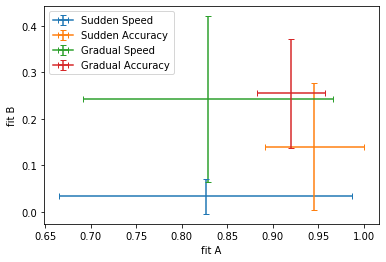

In [202]:
plot_fits(fit_A, fit_B)

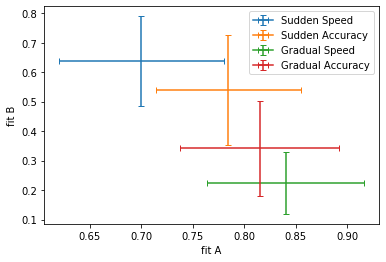

In [203]:
plot_fits(fit_transfer_A, fit_transfer_B)

In [157]:
def plot_collapsed_across_emphasis_fits(fit_A, fit_B):
    x = np.array([np.mean(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),np.mean(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    y = np.array([np.mean(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0),np.mean(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])
    x_err = np.array([stat.sem(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),stat.sem(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    y_err = np.array([stat.sem(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0), stat.sem(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])
    #x_err = np.array([stat.tstd(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),stat.tstd(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    #y_err = np.array([stat.tstd(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0), stat.tstd(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])

    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y

    #x_conf_interval = np.array(stat.norm.interval(0.95, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.95, loc = y, scale = y_err))
    #plt.errorbar(x, y, xerr = x_err, yerr = y_err, linestyle = 'None', capsize = 3)
    #plot0 = plt.errorbar(x[0], y[0], xerr = x_err[0], yerr = y_err[0], capsize = 3)
    #plot0 = plt.scatter(np.concatenate((fit_A[0::4], fit_A[1::4])), np.concatenate((fit_B[0::4], fit_B[1::4])))

    #plot1 = plt.errorbar(x[1], y[1], xerr = x_err[1], yerr = y_err[1], capsize = 3)
    #plot1 = plt.scatter(np.concatenate((fit_A[2::4], fit_A[3::4])), np.concatenate((fit_B[2::4], fit_B[3::4])))
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)

    #plot0 = plt.errorbar(x[0], y[0], xerr = x_conf_interval[:, 0], yerr = y_conf_interval[:, 0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_conf_interval[:, 1], yerr = y_conf_interval[:, 1], capsize = 3)
    #plot2 = plt.errorbar(x[2], y[2], xerr = x_conf_interval[:, 2], yerr = y_conf_interval[:, 2], capsize = 3)
    #plot3 = plt.errorbar(x[3], y[3], xerr = x_conf_interval[:, 3], yerr = y_conf_interval[:, 3], capsize = 3)

    plt.legend((plot0, plot1), ('Sudden', 'Gradual'))
    plt.xlabel('fit A')
    plt.ylabel('fit B')

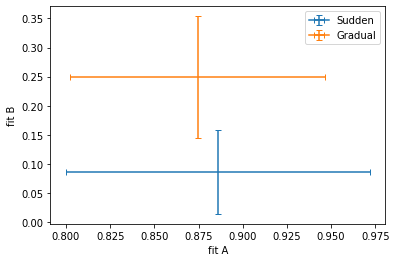

In [204]:
plot_collapsed_across_emphasis_fits(fit_A, fit_B)

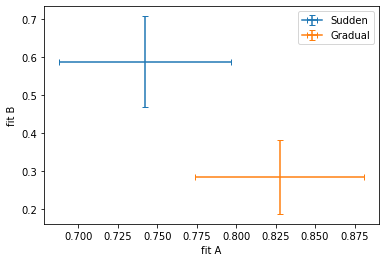

In [205]:
plot_collapsed_across_emphasis_fits(fit_transfer_A, fit_transfer_B)

In [206]:
def plot_collapsed_across_rotation_fits(fit_A, fit_B):
    x = np.array([np.nanmean(fit_A[0::2, :], axis = 0), np.nanmean(fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    y = np.array([np.nanmean(fit_B[0::2, :], axis = 0), np.nanmean(fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])

    #x = np.array([np.nanmean(fit_A[0::2, :] - fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    #y = np.array([np.nanmean(fit_B[0::2, :] - fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])

    x_err = np.array([stat.sem(fit_A[0::2, :], axis = 0), stat.sem(fit_A[1::2, :], axis = 0)])#, stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    y_err = np.array([stat.sem(fit_B[0::2, :], axis = 0), stat.sem(fit_B[1::2, :], axis = 0)])#, stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])

    #x_err = np.array([stat.tstd(fit_A[0::2, :], axis = 0), stat.tstd(fit_A[1::2, :], axis = 0)])#, stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    #y_err = np.array([stat.tstd(fit_B[0::2, :], axis = 0), stat.tstd(fit_B[1::2, :], axis = 0)])#, stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])

    #x_conf_interval = np.array(stat.norm.interval(0.83, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.83, loc = y, scale = y_err))

    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)


    #plot0 = plt.errorbar(x[0], y[0], xerr = x_err[0], yerr = y_err[0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_err[1], yerr = y_err[1], capsize = 3)
    #plot0 = plt.errorbar(x[0], y[0], xerr = x_conf_interval[:, 0], yerr = y_conf_interval[:, 0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_conf_interval[:, 1], yerr = y_conf_interval[:, 1], capsize = 3)
    #plot2 = plt.errorbar(x[2], y[2], xerr = x_conf_interval[:, 2], yerr = y_conf_interval[:, 2], capsize = 3)
    #plot3 = plt.errorbar(x[3], y[3], xerr = x_conf_interval[:, 3], yerr = y_conf_interval[:, 3], capsize = 3)
    print (x[0], y[0])
    plt.legend((plot0, plot1), ('Speed', 'Accuracy'))#, 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel('fit A')
    plt.ylabel('fit B')

[0.8275174] [0.13779161]


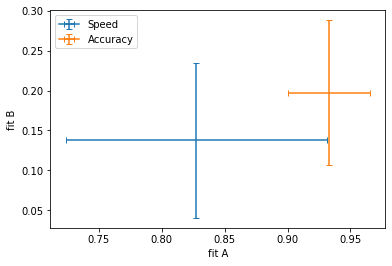

In [207]:
plot_collapsed_across_rotation_fits(fit_A, fit_B)

[0.77025441] [0.43096595]


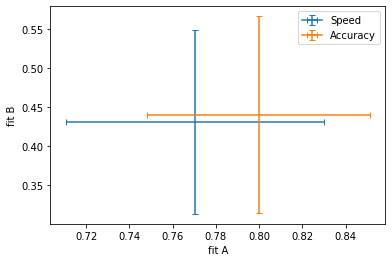

In [208]:
plot_collapsed_across_rotation_fits(fit_transfer_A, fit_transfer_B)

In [22]:
#np.mean(np.mean(error_sum[1::4], axis = 2), axis = 0)
#stat.sem(np.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_param_fits(fit_A, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = np.array([np.mean(fit_A[1::4]),
                     np.mean(fit_A[0::4]), 
                     np.mean(fit_A[3::4]),
                     np.mean(fit_A[2::4])])# - np.mean(np.median(distances[1::4], axis = 2), axis = 0)[10],
    y_sem = np.array([stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4])]) 
    #print (y_sem[0])
    #y_sem = np.array([0, 0, 0, 0])
    plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, fill = False)
    plt.bar(1, y[1], yerr = y_sem[1], capsize = 3, color = [0.5, 0.5, 0.5])
    plt.bar(2, y[2], yerr = y_sem[2], capsize = 3, hatch = '\\', fill = False)
    plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, hatch = '\\', color = [0.5, 0.5, 0.5])

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 1, 2, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('fit values')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    #plt.ylim(0, 45)
    print (y)
#np.shape(np.mean(error_sum[1::4], axis = 0))


In [159]:
#Target error: Angle between start to current and start to target cursor
def calc_target_error(percentage_trajectory):
    target_errors = np.zeros((60, 12, 64))
    for data in range(1000, 1060):
        for block in range(12):
            traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
            for trial in range(64):
                trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
                targetx, targety = trajx[-1], trajy[-1]
                partial_trajx, partial_trajy = get_partial_traj(data, block, trial, percentage_trajectory)
                angles = list()
                for i in range(len(partial_trajx[:-1])):
                    #print (trajx[i], trajy[i])
                    angles.append(calc_angle(np.array([0, 0]), np.array([partial_trajx[i], partial_trajy[i]]), np.array([trajx[-1], trajy[-1]])))  
                target_errors[data-1000][block][trial] = np.nanmean(angles)
    return target_errors

In [160]:
target_errors = calc_target_error(1)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


In [48]:
def calc_aiming_error(percentage_trajectory):
    aiming_errors = np.zeros((60, 12, 64))
    for data in range(1000, 1060):
        for block in range(12):
            traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
            for trial in range(64):
                trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
                targetx, targety = trajx[-1], trajy[-1]
                partial_trajx, partial_trajy = get_partial_traj(data, block, trial, percentage_trajectory)
                angles = list()
                for i in range(len(partial_trajx[:-1])):
                    #print (trajx[i], trajy[i])
                    angles.append(calc_angle(np.array([0, 0]), np.array([partial_trajx[i], partial_trajy[i]]), np.array([-trajx[-1], trajy[-1]])))  
                if data%4 == 2 or data%4 == 3:
                    aiming_errors[data-1000][block][trial] = np.nanmean(angles) - (90 - block*10)
                else:
                    aiming_errors[data-1000][block][trial] = np.nanmean(angles)

    return aiming_errors

In [231]:
aiming_errors = calc_aiming_error(1)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


In [38]:
def plot_errors_trials(num_points, first_trial, last_trial, errors, title_text):
    plt.figure(figsize=(20, 5))
    plot_0, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[0::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1), alpha = 0.5)
    plot_1, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[1::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1), alpha = 0.5)
    plot_2, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[2::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1))
    plot_3, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[3::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1))

    plt.legend((plot_0, plot_1, plot_2, plot_3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel('Trials')
    plt.ylabel('Angular Errors')
    plt.title(title_text)

# 2-state model

In [236]:
def dual_model_sudden(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    rotation = 90
    fast_est = 0
    slow_est = 0
    rotation_est = fast_est + slow_est
    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        rotation_est = fast_est + slow_est
        #print (rotation_est)
    return errors

def dual_model_gradual(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    fast_est = 0
    slow_est = 0
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials):
        if trial%64 == 0:
            if rotation != 90:
                rotation = rotation + 10
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        rotation_est = fast_est + slow_est
        #print (rotation_est)
    return errors

In [237]:
def residuals_sudden(params, num_trials, data_errors):
    model_errors = dual_model_sudden(num_trials, params[0], params[1], params[2], params[3])
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

In [238]:
def residuals_gradual(params, num_trials, data_errors):
    model_errors = dual_model_gradual(num_trials, params[0], params[1], params[2], params[3])
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

In [257]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits_dual(curvatures, num_trials, part_size, fit_A, fit_B):
    num_fits = int(num_trials/part_size)
    fit_As = np.zeros((60, num_fits))
    fit_Bs = np.zeros((60, num_fits))
    fit_Af = np.zeros((60, num_fits))
    fit_Bf = np.zeros((60, num_fits))
    fit_V = np.full((60, num_fits), np.inf)
    fit_success = np.zeros((60, num_fits))

    for participant in range(60):
        for fit_parts in range(num_fits):
            #starting_points = np.array([[fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.9, 0.2], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.99, 0.1], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.8, 0.3], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.7, 0.4], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.6, 0.5], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.5, 0.6], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.4, 0.7], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.3, 0.8], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.2, 0.9], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.1, 0.99],
            #                [0.9, 0.2, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.99, 0.1, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.8, 0.3, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.7, 0.4, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.6, 0.5, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.5, 0.6, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.4, 0.7, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.3, 0.8, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.2, 0.9, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.1, 0.99, fit_A[participant][fit_parts], fit_B[participant][fit_parts]]])
            #starting_points = np.array([[0.9, 0.2, 0.99, 0.02], [0.8, 0.3, 0.9, 0.03], [0.7, 0.4, 0.8, 0.04], [0.6, 0.5, 0.7, 0.05]])
            starting_points = np.array([[0.9, 0.2, 0.99, 0.02]])
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:      
                    #fits = scipy.optimize.minimize(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')            
                    fits = scipy.optimize.basinhopping(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})
                    
                    if fits.fun < fit_V[participant][fit_parts]:
                        fit_Af[participant][fit_parts] = fits.x[0]
                        fit_Bf[participant][fit_parts] = fits.x[1]
                        fit_As[participant][fit_parts] = fits.x[2]
                        fit_Bs[participant][fit_parts] = fits.x[3]
                        fit_V[participant][fit_parts] = fits.fun
                        #fit_success[participant][fit_parts] = fits.success                
                else:
                    #fits = scipy.optimize.minimize(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')         
                    fits = scipy.optimize.basinhopping(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})
                    if fits.fun < fit_V[participant][fit_parts]:
                        fit_Af[participant][fit_parts] = fits.x[0]
                        fit_Bf[participant][fit_parts] = fits.x[1]
                        fit_As[participant][fit_parts] = fits.x[2]
                        fit_Bs[participant][fit_parts] = fits.x[3]
                        fit_V[participant][fit_parts] = fits.fun
                        #fit_success[participant][fit_parts] = fits.success

        print (fits.fun)
    return fit_Af, fit_Bf, fit_As, fit_Bs, fit_V, fit_success
        

In [258]:
Af, Bf, As, Bs, fit_V_dual, fit_success_dual = run_fits_dual(curvatures_smooth, 640, 640, fit_A, fit_B)

178495.61238475758


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Tejas\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


81347.33855405595


C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


23228.9863721101
32048.545940530475
53727.13272105944
73429.85569893618
29094.716117059656
28662.192874071487
86889.36730600016
116848.68603806105
51097.53192860754
21779.296953469435
544539.6669669847
94462.77277125925
110165.94149079986
15364.91088791128
102293.71575219001
57838.13228524553
22301.642106993197
36798.977525510185
94045.28867625646
92364.62670680381
75540.51292840557
33914.85448348578
104355.52495467654
64807.04372433421
49307.16844628367
50317.648076790065
412369.70410926914
124565.49202562371
30723.754068566792
30562.70546827284
55965.30422679499
74844.88529994924
24277.246922020935
19300.515556075414
161376.4528489173
142623.1274912663
52146.004444510654
24195.43561377816
595475.6952403204
58900.40929604088
92936.79906893699
29881.088869419837
97871.17674538706
202721.56144019502
133534.94058420745
28352.752654685937
255153.6041489806
106281.85955100533
39106.260444282394
39714.66890848616
133305.82624343183
101971.66171135214
32499.609601312768
24346.377110231722
76

In [53]:
#plot_param_fits(As, "A slow")
#plot_param_fits(Af, "A fast")

<IPython.core.display.Javascript object>


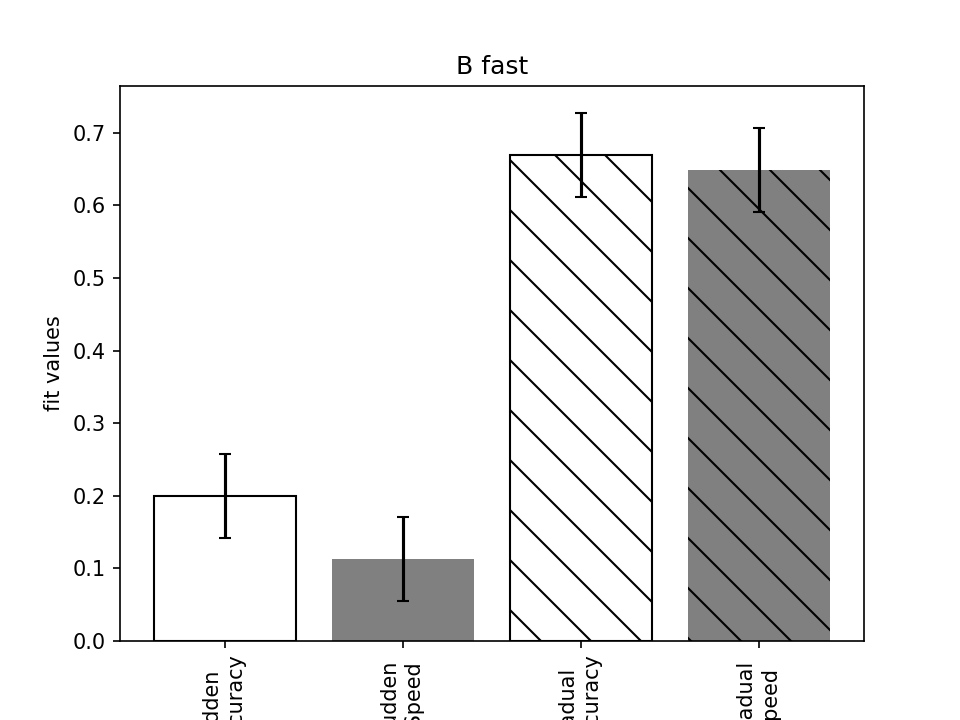

[0.19937675 0.11229053 0.66982926 0.64866456]


In [209]:
#plot_param_fits(Bs, "B slow")
plot_param_fits(Bf, "B fast")

In [259]:
Aslows = np.array([np.mean(As[0::4], axis = 0), np.mean(As[1::4], axis = 0), np.mean(As[2::4], axis = 0), np.mean(As[3::4], axis = 0)])
Bslows = np.array([np.mean(Bs[0::4], axis = 0), np.mean(Bs[1::4], axis = 0), np.mean(Bs[2::4], axis = 0), np.mean(Bs[3::4], axis = 0)])
Afasts = np.array([np.mean(Af[0::4], axis = 0), np.mean(Af[1::4], axis = 0), np.mean(Af[2::4], axis = 0), np.mean(Af[3::4], axis = 0)])
Bfasts = np.array([np.mean(Bf[0::4], axis = 0), np.mean(Bf[1::4], axis = 0), np.mean(Bf[2::4], axis = 0), np.mean(Bf[3::4], axis = 0)])
Aserrors = np.array([stat.sem(As[0::4], axis = 0), stat.sem(As[1::4], axis = 0), stat.sem(As[2::4], axis = 0), stat.sem(As[3::4], axis = 0)])
Bserrors = np.array([stat.sem(Bs[0::4], axis = 0), stat.sem(Bs[1::4], axis = 0), stat.sem(Bs[2::4], axis = 0), stat.sem(Bs[3::4], axis = 0)])
Aferrors = np.array([stat.sem(Af[0::4], axis = 0), stat.sem(Af[1::4], axis = 0), stat.sem(Af[2::4], axis = 0), stat.sem(Af[3::4], axis = 0)])
Bferrors = np.array([stat.sem(Bf[0::4], axis = 0), stat.sem(Bf[1::4], axis = 0), stat.sem(Bf[2::4], axis = 0), stat.sem(Bf[3::4], axis = 0)])

#Aserrors = np.array([stat.tstd(As[0::4], axis = 0), stat.tstd(As[1::4], axis = 0), stat.tstd(As[2::4], axis = 0), stat.tstd(As[3::4], axis = 0)])
#Bserrors = np.array([stat.tstd(Bs[0::4], axis = 0), stat.tstd(Bs[1::4], axis = 0), stat.tstd(Bs[2::4], axis = 0), stat.tstd(Bs[3::4], axis = 0)])
#Aferrors = np.array([stat.tstd(Af[0::4], axis = 0), stat.tstd(Af[1::4], axis = 0), stat.tstd(Af[2::4], axis = 0), stat.tstd(Af[3::4], axis = 0)])
#Bferrors = np.array([stat.tstd(Bf[0::4], axis = 0), stat.tstd(Bf[1::4], axis = 0), stat.tstd(Bf[2::4], axis = 0), stat.tstd(Bf[3::4], axis = 0)])


Text(0, 0.5, 'B')

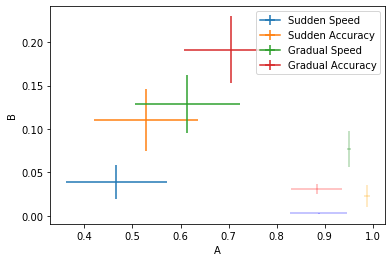

In [260]:
plot0 = plt.errorbar(Aslows[0], Bslows[0], xerr=Aserrors[0], yerr=Bserrors[0], alpha = 0.3, color = 'Blue')
plot1 = plt.errorbar(Aslows[1], Bslows[1], xerr=Aserrors[1], yerr=Bserrors[1], alpha = 0.3, color = 'Orange')
plot2 = plt.errorbar(Aslows[2], Bslows[2], xerr=Aserrors[2], yerr=Bserrors[2], alpha = 0.3, color = 'Red')
plot3 = plt.errorbar(Aslows[3], Bslows[3], xerr=Aserrors[3], yerr=Bserrors[3], alpha = 0.3, color = 'Green')

plot0 = plt.errorbar(Afasts[0], Bfasts[0], xerr=Aferrors[0], yerr=Bferrors[0])
plot1 = plt.errorbar(Afasts[1], Bfasts[1], xerr=Aferrors[1], yerr=Bferrors[1])
plot2 = plt.errorbar(Afasts[2], Bfasts[2], xerr=Aferrors[2], yerr=Bferrors[2])
plot3 = plt.errorbar(Afasts[3], Bfasts[3], xerr=Aferrors[3], yerr=Bferrors[3])
plt.legend((plot0, plot1, plot2, plot3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
plt.xlabel("A")
plt.ylabel('B')

## Collapse Across Sudden Gradual

In [261]:
Aslows = np.array([np.mean(As[0::2], axis = 0), np.mean(As[1::2], axis = 0)])#, np.mean(As[2::4], axis = 0), np.mean(As[3::4], axis = 0)])
Bslows = np.array([np.mean(Bs[0::2], axis = 0), np.mean(Bs[1::2], axis = 0)])#, np.mean(Bs[2::4], axis = 0), np.mean(Bs[3::4], axis = 0)])
Afasts = np.array([np.mean(Af[0::2], axis = 0), np.mean(Af[1::2], axis = 0)])#, np.mean(Af[2::4], axis = 0), np.mean(Af[3::4], axis = 0)])
Bfasts = np.array([np.mean(Bf[0::2], axis = 0), np.mean(Bf[1::2], axis = 0)])#, np.mean(Bf[2::4], axis = 0), np.mean(Bf[3::4], axis = 0)])
Aserrors = np.array([stat.sem(As[0::2], axis = 0), stat.sem(As[1::2], axis = 0)])#, stat.sem(As[2::4], axis = 0), stat.sem(As[3::4], axis = 0)])
Bserrors = np.array([stat.sem(Bs[0::2], axis = 0), stat.sem(Bs[1::2], axis = 0)])#, stat.sem(Bs[2::4], axis = 0), stat.sem(Bs[3::4], axis = 0)])
Aferrors = np.array([stat.sem(Af[0::2], axis = 0), stat.sem(Af[1::2], axis = 0)])#, stat.sem(Af[2::4], axis = 0), stat.sem(Af[3::4], axis = 0)])
Bferrors = np.array([stat.sem(Bf[0::2], axis = 0), stat.sem(Bf[1::2], axis = 0)])#, stat.sem(Bf[2::4], axis = 0), stat.sem(Bf[3::4], axis = 0)])

#Aserrors = np.array([stat.tstd(As[0::2], axis = 0), stat.tstd(As[1::2], axis = 0)])#, stat.tstd(As[2::4], axis = 0), stat.tstd(As[3::4], axis = 0)])
#Bserrors = np.array([stat.tstd(Bs[0::2], axis = 0), stat.tstd(Bs[1::2], axis = 0)])#, stat.tstd(Bs[2::4], axis = 0), stat.tstd(Bs[3::4], axis = 0)])
#Aferrors = np.array([stat.tstd(Af[0::2], axis = 0), stat.tstd(Af[1::2], axis = 0)])#, stat.tstd(Af[2::4], axis = 0), stat.tstd(Af[3::4], axis = 0)])
#Bferrors = np.array([stat.tstd(Bf[0::2], axis = 0), stat.tstd(Bf[1::2], axis = 0)])#, stat.tstd(Bf[2::4], axis = 0), stat.tstd(Bf[3::4], axis = 0)])


Text(0, 0.5, 'B')

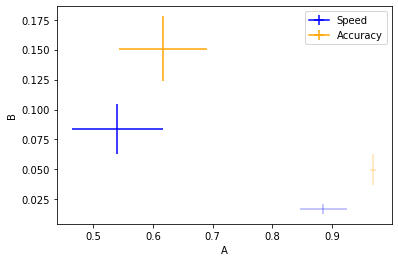

In [262]:
plot0 = plt.errorbar(Aslows[0], Bslows[0], xerr=Aserrors[0], yerr=Bserrors[0], alpha = 0.3, color = 'Blue')
plot1 = plt.errorbar(Aslows[1], Bslows[1], xerr=Aserrors[1], yerr=Bserrors[1], alpha = 0.3, color = 'Orange')
#plot2 = plt.errorbar(Aslows[2], Bslows[2], xerr=Aserrors[2], yerr=Bserrors[2], alpha = 0.3, color = 'Red')
#plot3 = plt.errorbar(Aslows[3], Bslows[3], xerr=Aserrors[3], yerr=Bserrors[3], alpha = 0.3, color = 'Green')

plot0 = plt.errorbar(Afasts[0], Bfasts[0], xerr=Aferrors[0], yerr=Bferrors[0], color = 'Blue')
plot1 = plt.errorbar(Afasts[1], Bfasts[1], xerr=Aferrors[1], yerr=Bferrors[1], color = 'Orange')
#plot2 = plt.errorbar(Afasts[2], Bfasts[2], xerr=Aferrors[2], yerr=Bferrors[2])
#plot3 = plt.errorbar(Afasts[3], Bfasts[3], xerr=Aferrors[3], yerr=Bferrors[3])
plt.legend((plot0, plot1), ('Speed','Accuracy'))
plt.xlabel("A")
plt.ylabel('B')

## Collapsing across Speed/Accuracy

In [265]:
Aslows = np.array([np.mean(np.concatenate((As[0::4], As[0::4])), axis = 0), np.mean(np.concatenate((As[2::4], As[3::4])), axis = 0)])
Bslows = np.array([np.mean(np.concatenate((Bs[0::4], Bs[0::4])), axis = 0), np.mean(np.concatenate((Bs[2::4], Bs[3::4])), axis = 0)])
Afasts = np.array([np.mean(np.concatenate((Af[0::4], Af[0::4])), axis = 0), np.mean(np.concatenate((Af[2::4], Af[3::4])), axis = 0)])
Bfasts = np.array([np.mean(np.concatenate((Bf[0::4], Bf[0::4])), axis = 0), np.mean(np.concatenate((Bf[2::4], Bf[3::4])), axis = 0)])

#Aserrors = np.array([stat.sem(np.concatenate((As[0::4], As[0::4])), axis = 0), stat.sem(np.concatenate((As[2::4], As[3::4])), axis = 0)])
#Bserrors = np.array([stat.sem(np.concatenate((Bs[0::4], Bs[0::4])), axis = 0), stat.sem(np.concatenate((Bs[2::4], Bs[3::4])), axis = 0)])
#Aferrors = np.array([stat.sem(np.concatenate((Af[0::4], Af[0::4])), axis = 0), stat.sem(np.concatenate((Af[2::4], Af[3::4])), axis = 0)])
#Bferrors = np.array([stat.sem(np.concatenate((Bf[0::4], Bf[0::4])), axis = 0), stat.sem(np.concatenate((Bf[2::4], Bf[3::4])), axis = 0)])

Aserrors = np.array([stat.tstd(np.concatenate((As[0::4], As[0::4])), axis = 0), stat.tstd(np.concatenate((As[2::4], As[3::4])), axis = 0)])
Bserrors = np.array([stat.tstd(np.concatenate((Bs[0::4], Bs[0::4])), axis = 0), stat.tstd(np.concatenate((Bs[2::4], Bs[3::4])), axis = 0)])
Aferrors = np.array([stat.tstd(np.concatenate((Af[0::4], Af[0::4])), axis = 0), stat.tstd(np.concatenate((Af[2::4], Af[3::4])), axis = 0)])
Bferrors = np.array([stat.tstd(np.concatenate((Bf[0::4], Bf[0::4])), axis = 0), stat.tstd(np.concatenate((Bf[2::4], Bf[3::4])), axis = 0)])



Text(0, 0.5, 'B')

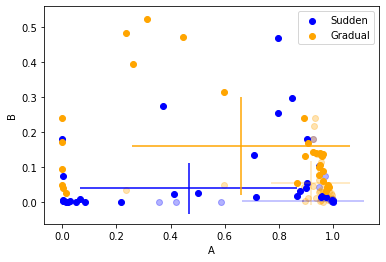

In [266]:
plot0 = plt.errorbar(Aslows[0], Bslows[0], xerr=Aserrors[0], yerr=Bserrors[0], alpha = 0.3, color = 'Blue')
plot1 = plt.errorbar(Aslows[1], Bslows[1], xerr=Aserrors[1], yerr=Bserrors[1], alpha = 0.3, color = 'Orange')
#plot2 = plt.errorbar(Aslows[2], Bslows[2], xerr=Aserrors[2], yerr=Bserrors[2], alpha = 0.3, color = 'Red')
#plot3 = plt.errorbar(Aslows[3], Bslows[3], xerr=Aserrors[3], yerr=Bserrors[3], alpha = 0.3, color = 'Green')
plot0 = plt.scatter(np.concatenate((As[0::4], As[1::4])), np.concatenate((Bs[0::4], Bs[1::4])), alpha = 0.3, color = 'Blue')
plot1 = plt.scatter(np.concatenate((As[2::4], As[3::4])), np.concatenate((Bs[2::4], Bs[3::4])), alpha = 0.3, color = 'Orange')


plot0 = plt.errorbar(Afasts[0], Bfasts[0], xerr=Aferrors[0], yerr=Bferrors[0], color = 'Blue')
plot1 = plt.errorbar(Afasts[1], Bfasts[1], xerr=Aferrors[1], yerr=Bferrors[1], color = 'Orange')
#plot2 = plt.errorbar(Afasts[2], Bfasts[2], xerr=Aferrors[2], yerr=Bferrors[2])
#plot3 = plt.errorbar(Afasts[3], Bfasts[3], xerr=Aferrors[3], yerr=Bferrors[3])
plot0 = plt.scatter(np.concatenate((Af[0::4], Af[1::4])), np.concatenate((Bf[0::4], Bf[1::4])), color = 'Blue')
plot1 = plt.scatter(np.concatenate((Af[2::4], Af[3::4])), np.concatenate((Bf[2::4], Bf[3::4])), color = 'Orange')

plt.legend((plot0, plot1), ('Sudden','Gradual'))
plt.xlabel("A")
plt.ylabel('B')

In [134]:
fit_V_single_state = fit_V


In [162]:
np.mean(fit_transfer_V)

8049.162100068025

In [135]:
np.mean(fit_V)

95908.70196157394

In [267]:
np.mean(fit_V)

485969.28301296674

In [269]:
np.mean(fit_V_dual)

94373.96916781281

# % Variance accounted for

In [229]:
1 - np.sum(fit_transfer_V)/np.nansum((np.ravel(curvatures[:, 11, :]) - np.nanmean(curvatures[:, 11, :]))**2)

0.14992304958039027

In [252]:
1 - np.sum(fit_V)/np.nansum((np.ravel(curvatures[:, 1:-1, :]) - np.nanmean(curvatures[:, 1:-1, :]))**2)

0.4830259518291956

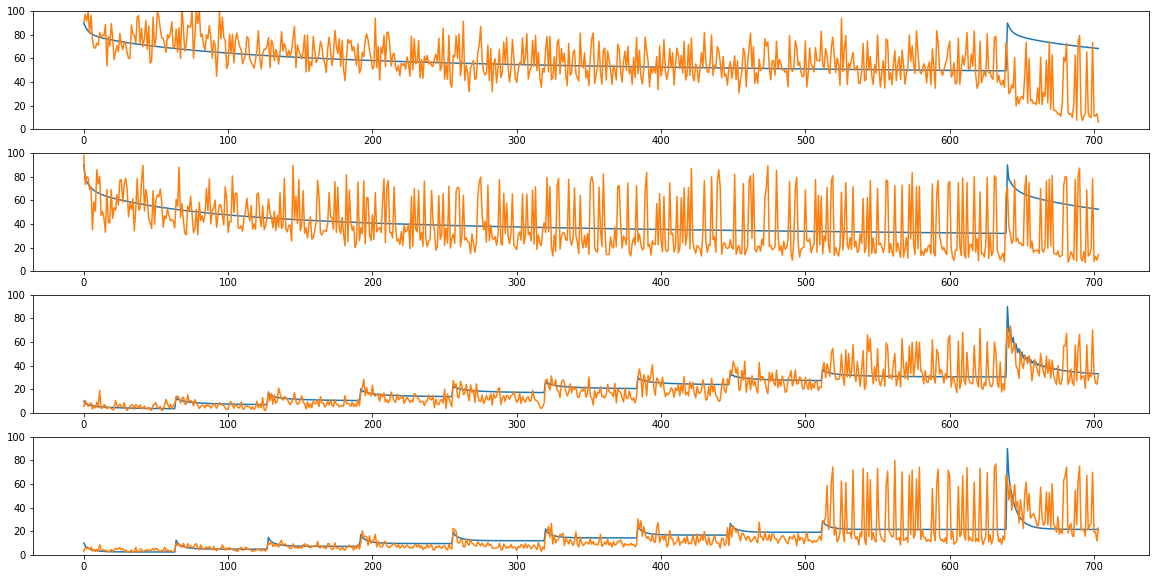

In [235]:
plt.figure(figsize = (20, 10))
errors_predict = np.zeros((60, 704))

for participant in range(60):
    if participant % 4 == 0 or participant%4 == 1:
        errors_predict[participant][:640] = base_model_sudden(640, fit_A[participant], fit_B[participant])

    else:    
        errors_predict[participant][:640] = base_model_gradual(640, fit_A[participant], fit_B[participant])

    errors_predict[participant][640:] = base_model_transfer(64, fit_A[participant], fit_B[participant])

for participant in range(4):
    if participant % 4 == 0 or participant%4 == 1:
        plt.subplot(4, 1, participant + 1 )
        plt.plot(np.mean(errors_predict[participant::4], axis = 0))
        plt.plot(np.ravel(np.mean(curvatures[participant::4], axis = 0)[1:]))
    else:
        plt.subplot(4, 1, participant + 1 )
        plt.plot(np.mean(errors_predict[participant::4], axis = 0))
        plt.plot(np.ravel(np.mean(curvatures[participant::4], axis = 0)[1:]))
    plt.ylim((0, 100))


In [144]:
import pandas as pd

In [216]:
df_A = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_A": fit_A[:, 0]})

In [217]:
model_A = ols('fit_A ~ C(Emphasis)*C(Rotation)', data = df_A).fit()

In [218]:
aov_table_A = sm.stats.anova_lm(model_A)


In [219]:
df_B = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_B": fit_B[:, 0]})

In [220]:
model_B = ols('fit_B ~ C(Emphasis)*C(Rotation)', data = df_B).fit()
aov_table_B = sm.stats.anova_lm(model_B)


In [221]:
aov_table_B

,df,sum_sq,mean_sq,F,PR(>F)
C(Emphasis),1.0,0.053256,0.053256,0.831120,0.365857
C(Rotation),1.0,0.396558,0.396558,6.188771,0.015860
C(Emphasis):C(Rotation),1.0,0.033360,0.033360,0.520623,0.473578
Residual,56.0,3.588312,0.064077,NaN,NaN


In [222]:
aov_table_A

,df,sum_sq,mean_sq,F,PR(>F)
C(Emphasis),1.0,0.166506,0.166506,3.478504,0.067414
C(Rotation),1.0,0.001972,0.001972,0.041192,0.839903
C(Emphasis):C(Rotation),1.0,0.002901,0.002901,0.060602,0.806448
Residual,56.0,2.680560,0.047867,NaN,NaN


# Check for Predictions on the transfer block

In [64]:
errors_predict = np.zeros((60, 1, 64))

In [67]:
for participant in range(60):
    errors_predict[participant][0][:] = base_model_sudden(64, fit_A[participant], fit_B[participant])

In [87]:
np.sum((errors_predict - curvatures_smooth[:, 11])**2)

258958614.33577323

In [88]:
for participant in range(2, 62):
    errors_predict[participant - 2][0][:] = base_model_sudden(64, fit_A[participant], fit_B[participant])

IndexError: index 60 is out of bounds for axis 0 with size 60